In [2]:
from __future__ import division

import os
from os.path import join

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold

from nilearn.image import index_img
from nilearn.image import load_img
from nilearn.image import mean_img
from nilearn.image import new_img_like
from nilearn.decoding import SearchLight

%pylab inline

/home/natalie/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


# Classification 
This notebook runs SVM-based searchlights across a variety of classification problems. For a detailed walkthrough of the individual steps for setting up a single classifier, see TDLS_sandbox.ipynb in this same directory

## fMRI preprocessing
For this analysis, the functional data has been preprocessed with the following steps:

* motion correction
* non-brain removal with BET (along with func mask creation)
* 4mm smoothing
* highpass filtered (Gaussian least-squares straight-line fitting, sigma=40.0s)

In addition, we ran first level GLMs to extract SPMs that represented single trial parameter estimates. For each trial, a model was fit with two regressors: 
1. convolved regressor representing THAT trial
2. convolved regressor representing ALL OTHER trials. 

The unique parameter estimate map for each trial was extracted and merged across time to produce a 4D file. There are 48 'timepts' in this 4D file, each representing the whole brain parameter estimate map for a single trial

The 4D single-trial parameter maps will be used as the input dataset for our classification
This experiment was a single run task with 48 trials. On each trial, subjects were presented with a stimulus in the form of either a **Word** or a **Picture** (24 stims from each modality).


## Task info
Stimuli represented either **Dwellings** or **Tools** (equally balanced across modalities). 

There were 8 unique stimuli. 

** Stimuli Breakdown:**

* 24 Words
    * 12 Dwellings
        * 4 stims (as words), repeated 3x each
    * 12 Tools 
        * 4 stims (as words), repeated 3x each
* 24 Pics
    * 12 Dwellings
        * 4 stims (as pics), repeated 3x each
    * 12 Tools
        * 4 stims (as pics), repeated 3x each


## Classifiers
For each subject, we run the following searchlights across the whole brain, attempting to classify between
* Modality (word vs picture overall)
* Category (dwelling vs tool overall)
* Stimulus (unique stimulus overall)
* categoryWords (dwelling vs tool, words only)
* categoryPics(dwelling vs tool, pics only)
* stimulusWords (unique stim, words only)
* stimulusPics (unique stim, pics only)

---

In [3]:
# path to the data directory for all subjects
dataDir = '../data'

In [5]:
### Methods for prepping target labels 
def catByWord(row):
    if row['Modality'] == 'Word':
        label = row['Category'] + 'Word'
    else:
        label = 'n'
    return label

def catByPic(row):
    if row['Modality'] == 'Picture':
        label = row['Category'] + 'Pic'
    else:
        label = 'n'
    return label

def stimByWord(row):
    if row['Modality'] == 'Word':
        label = row['Stimulus'] + 'Word'
    else:
        label = 'n'
    return label

def stimByPic(row):
    if row['Modality'] == 'Picture':
        label = row['Stimulus'] + 'Pic'
    else:
        label = 'n'
    return label


def prepTargets(trialOnsets_fname):
    """
    Take the trial onsets table convert it into a table of target labels. 
    The resulting table will be [nFeatures x nClassifiers], where each col
    represents the target labels for a given classification problem (e.g. words vs pics)
    """
    # read the trial onsets
    trialOnsets = pd.read_table(trialOnsets_fname)
    
    # drop the TrialOnset time column
    trialLabels = trialOnsets.drop('TrialOnset', axis=1)
    
    # 'trials' already has columns labeling rows by Modality, Category, and Stimulus.
    # add additional columns for the following labels
    trialLabels['categoryWords'] = trialLabels.apply(catByWord, axis=1)
    trialLabels['categoryPics'] = trialLabels.apply(catByPic, axis=1)
    trialLabels['stimulusWords'] = trialLabels.apply(stimByWord, axis=1)
    trialLabels['stimulusPics'] = trialLabels.apply(stimByPic, axis=1)
    
    return trialLabels
    
    


In [6]:
prepTargets('/projects/RRF13/TDLS_classify/data/13034/13034_trialOnsets.txt')

,Modality,Category,Stimulus,categoryWords,categoryPics,stimulusWords,stimulusPics
0,Word,dwelling,castle,dwellingWord,n,castleWord,n
1,Word,tool,saw,toolWord,n,sawWord,n
2,Word,dwelling,house,dwellingWord,n,houseWord,n
3,Word,dwelling,tent,dwellingWord,n,tentWord,n
4,Word,tool,screwdriver,toolWord,n,screwdriverWord,n
5,Word,dwelling,igloo,dwellingWord,n,iglooWord,n
6,Word,tool,pliers,toolWord,n,pliersWord,n
7,Word,tool,hammer,toolWord,n,hammerWord,n
8,Word,dwelling,tent,dwellingWord,n,tentWord,n
9,Word,tool,hammer,toolWord,n,hammerWord,n


In [10]:
def runAllClassifiers(subj):
    """
    For a given subject, prep all input data
    and loop over all classifications
    """
    subj = '13034'
    subjDataDir = join(dataDir, subj)
    outputDir = join(dataDir, subj, 'searchLights')
    if not os.path.isdir(outputDir):
        os.makedirs(outputDir)
        
    # create a variable that will store a dataframe of all results for this subject and get returned to the
    # parent function
    subj_df = None
    
    ### input paths
    singleTrialPEs_file = join(subjDataDir, 'singleTrialGLM/singleTrialPEs.nii.gz')  # features matrix
    mask_file = join(subjDataDir, 'masks/TDSL2_brain_mask.nii.gz')  # functional data mask
    trialOnsets_file = join(subjDataDir, (subj + '_trialOnsets.txt'))      # trial onsets file
    
    ### prep target labels
    targets = prepTargets(trialOnsets_file)
    
    ### load mask
    mask_img = load_img(mask_file)
    
    # Each column in 'targets' represents a different classification problem to try for this subj
    for classProb in targets.columns:
    #for classProb in ['stimulusWords']:
        print('classifying subj {} based on {}'.format(subj, classProb))
        
        # get the target labels for this problem
        targetLabels = targets[classProb]
        
        # for some classifiers, not all trials apply. E.g. categoryWords can exclude
        # all trials that were pictures. So set up a mask for the samples
        samplesMask = targetLabels != 'n'
        
        # load the nifti image (masking for specified samples only)
        fmri = index_img(singleTrialPEs_file, samplesMask)
        
        # apply the same samples mask to the target labels
        targetLabels = targetLabels[samplesMask]

        # create mean image
        mean_fmri = mean_img(fmri)
        
        # set the number of splits for the K-fold cross validation. This number 
        # has to be less than or equal to the number of members of each class. Thus, 
        # for stimulusWords, and stimulusPics, it has to be set to 3 or lower
        if classProb in ['stimulusWords', 'stimulusPics']:
            nSplits=3
        else:
            nSplits=5
        
        # run the searchlight
        #try:
        results = runSearchLight(niftiData=fmri, labels=targetLabels, mask=mask_img, nSplits=nSplits)

        ### process the results
        # max accuracy across whole brain
        maxAccuracy = results.scores_.max()

        # location of voxel with max accuracy
        voxIdx = np.argmax(results.scores_)
        voxCoords = np.unravel_index(voxIdx, results.scores_.shape)

        radius = results.get_params()['radius']

        # store whole brain map
        results_img = new_img_like(mean_fmri, results.scores_)
        output_fname = '{}_r{:.1f}_{}.nii.gz'.format(subj, radius, classProb)
        results_img.to_filename(join(outputDir, output_fname))
        
        # store the relevant results in a dict
        thisResult = pd.DataFrame({'Subj': subj,
                      'Classification': classProb,
                      'maxAcc': maxAccuracy,
                      'maxVox':','.join([str(x) for x in voxCoords]),
                      'radius': radius}, index=[0])

        if subj_df is None:
            subj_df = thisResult
        else:
            subj_df = pd.concat([subj_df, thisResult], ignore_index=True)

        # print results
        print('Subj {}:, {} - max acc {:.1f}%, {:.1f}mm radius sphere at {}'.format(subj, 
                                                                                    classProb, 
                                                                                    maxAccuracy*100, 
                                                                                    radius,
                                                                                    voxCoords))

#         except Exception as e:
#             print('Error while classifying subj {} based on {}'.format(subj, classProb))
#             print(e)
            
    # After running all classifiers for this subject, return the dataframe with all results
    return subj_df

        

In [25]:
def runSearchLight(niftiData=None, labels=None, mask=None, nSplits=5):
    """
    Run a searchlight classifier on the supplied dataset. 
    Inputs:
        niftiData: a 4D nifit image (nibabel)
        labels: labels you want to base classification on (len(labels) should equal the number of timepts in niftiData)
        mask: mask nifti image (nibabel)
        nSplits: number of splits in KFold (must be less than the )
    """   
    # specify how you want to handle cross-validation. Here, a
    # stratifiedKFold approach is used, which will ensure an even balance
    # of samples from each category in the train and test sets
    skf = StratifiedKFold(n_splits=nSplits, random_state=1)

    # prep the searchlight object
    radius = 5.0
    searchlight = SearchLight(
                mask, 
                radius=radius,
                n_jobs=-1,
                verbose=0,
                scoring='accuracy',
                cv=skf)

    # run the search light (NOTE: this will make your CPU sing)
    searchlight.fit(niftiData, labels)
    
    return searchlight

In [49]:
subjs = ['13034', '13035', '13036',
        '13038', '13039', '13040']

allResults = None
for subj in subjs:
    subj_df =  runAllClassifiers(subj)
    
    if subj_df is not None:
        # combine this subjects results with the rest
        if allResults is None:
            allResults = subj_df
        else:
            allResults = pd.concat([allResults, subj_df], ignore_index=True)

classifying subj 13034 based on Modality
Subj 13034:, Modality - max acc 77.0%, 5.0mm radius sphere at (35, 9, 4)
classifying subj 13034 based on Category
Subj 13034:, Category - max acc 89.0%, 5.0mm radius sphere at (39, 13, 5)
classifying subj 13034 based on Stimulus
Subj 13034:, Stimulus - max acc 36.2%, 5.0mm radius sphere at (29, 51, 7)
classifying subj 13034 based on categoryWords
Subj 13034:, categoryWords - max acc 96.7%, 5.0mm radius sphere at (25, 28, 11)
classifying subj 13034 based on categoryPics
Subj 13034:, categoryPics - max acc 100.0%, 5.0mm radius sphere at (36, 39, 7)
classifying subj 13034 based on stimulusWords
Subj 13034:, stimulusWords - max acc 50.0%, 5.0mm radius sphere at (18, 28, 3)
classifying subj 13034 based on stimulusPics
Subj 13034:, stimulusPics - max acc 45.8%, 5.0mm radius sphere at (25, 26, 1)
classifying subj 13035 based on Modality
Subj 13035:, Modality - max acc 81.5%, 5.0mm radius sphere at (43, 18, 1)
classifying subj 13035 based on Category
Su

In [52]:
allResults = allResults[['Subj', 'Classification', 'maxAcc', 'maxVox', 'radius']]

In [53]:
allResults

,Subj,Classification,maxAcc,maxVox,radius
0,13034,Modality,0.770000,"35,9,4",5.0
1,13034,Category,0.890000,"39,13,5",5.0
2,13034,Stimulus,0.362500,"29,51,7",5.0
3,13034,categoryWords,0.966667,"25,28,11",5.0
4,13034,categoryPics,1.000000,"36,39,7",5.0
5,13034,stimulusWords,0.500000,"18,28,3",5.0
6,13034,stimulusPics,0.458333,"25,26,1",5.0
7,13035,Modality,0.815000,"43,18,1",5.0
8,13035,Category,0.790000,"26,30,3",5.0
9,13035,Stimulus,0.387500,"47,33,15",5.0


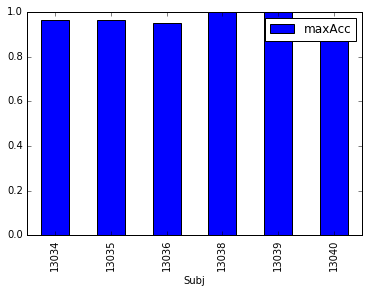

In [65]:
allResults.loc[allResults.Classification == 'categoryWords'].plot(
    x='Subj', 
    y='maxAcc', 
    kind='bar')